In [13]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [14]:
dpe = DPE('COM6')

Connecting to serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.03s
Serial disconnected


In [15]:
dpe.set_clock(50)

Connecting to serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [16]:
g = dpe.read(1)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


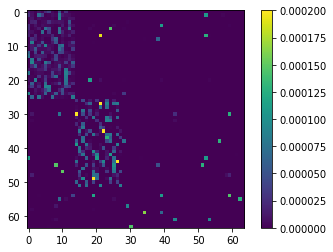

In [17]:
plt.imshow(g)
plt.clim(0, 2e-4)
plt.colorbar()

In [18]:
nn = NN_dpe(weights)

In [19]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [20]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Connecting to serial
[INFO] Elapsed time = 1.49s
Serial disconnected


In [21]:
outputs.shape

(400, 14)

In [24]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

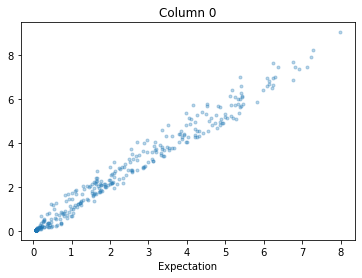

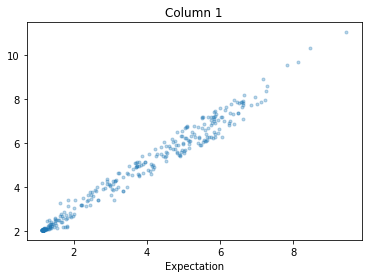

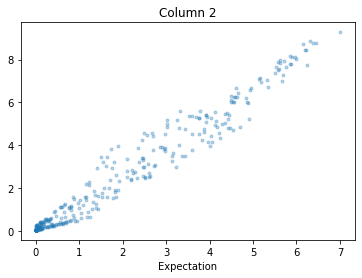

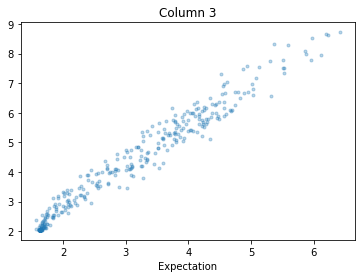

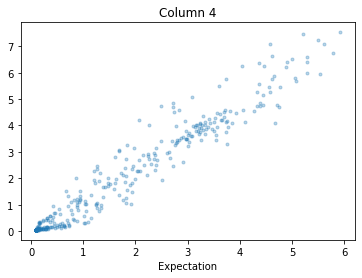

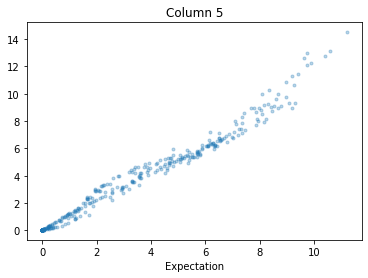

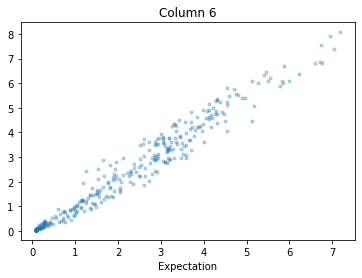

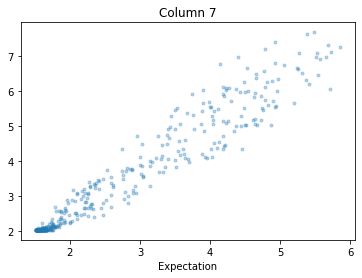

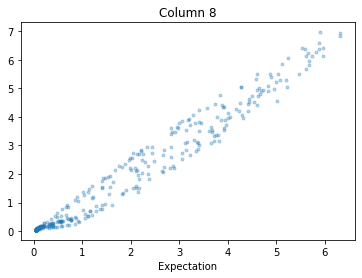

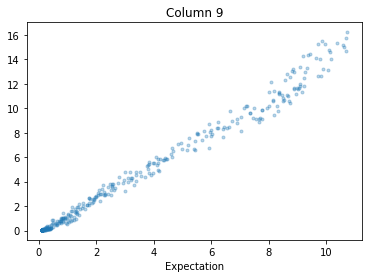

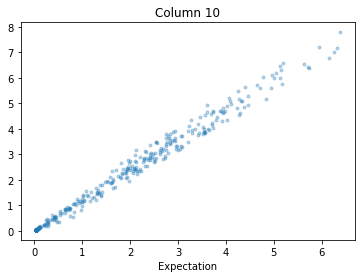

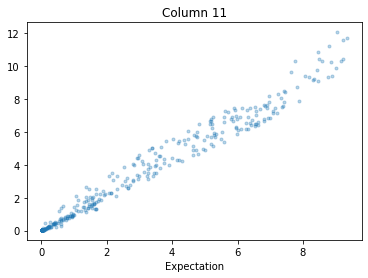

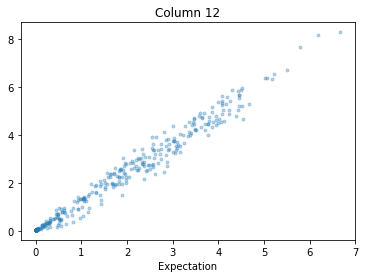

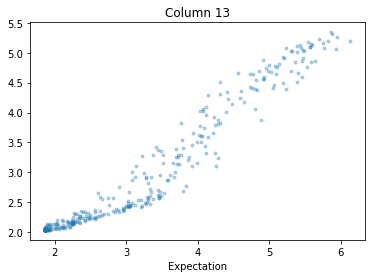

In [25]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

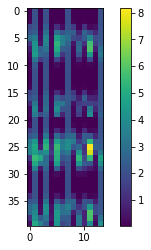

In [26]:
plt.imshow(software[:40])
plt.colorbar()

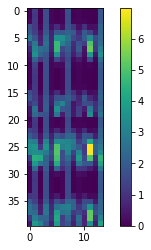

In [27]:
plt.imshow(outputs[:40])
plt.colorbar()

In [28]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.10600809,  0.02558262],
       [ 1.0400355 ,  0.85863644],
       [ 1.30230276,  0.00215507],
       [ 1.44122246, -0.16235268],
       [ 1.23063979, -0.09618758],
       [ 1.08255167,  0.03345652],
       [ 1.10381478, -0.07628634],
       [ 1.23586714,  0.08344223],
       [ 1.06021022, -0.08062452],
       [ 1.37758174, -0.16723768],
       [ 1.17893294,  0.0187636 ],
       [ 1.12354446,  0.03942665],
       [ 1.22563643,  0.01260009],
       [ 0.79969926,  0.41632605]])

In [29]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [31]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [32]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [100]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [101]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [102]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

In [103]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [104]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [105]:
xs.shape

(10000, 113)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


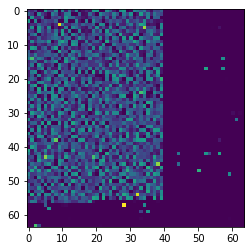

In [106]:
plt.imshow(dpe.read(2))

In [107]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [108]:
output1 = dpe.multiply(2, x1, c_sel=[0, 20])
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(2, x2, c_sel=[20, 40])
software2 = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 1.93s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 1.92s
Serial disconnected


In [109]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [110]:
lin_cor_fc2

[array([1.52191811e+01, 1.66377471e-05]),
 array([ 1.69177898e+01, -6.78931180e-05]),
 array([ 1.79615940e+01, -1.92130693e-04]),
 array([ 1.74461057e+01, -1.20232686e-04]),
 array([ 1.57870008e+01, -6.76431671e-05]),
 array([ 1.71696840e+01, -1.35285917e-04]),
 array([ 1.77565656e+01, -1.08992528e-04]),
 array([ 1.81531335e+01, -5.41870729e-05]),
 array([1.53276411e+01, 2.27732813e-05]),
 array([ 1.68668782e+01, -1.67805882e-04]),
 array([ 1.8302408e+01, -4.2873522e-05]),
 array([ 1.71393003e+01, -1.45734647e-04]),
 array([ 1.70547060e+01, -5.51509733e-05]),
 array([ 1.66509507e+01, -1.98654188e-05]),
 array([1.45977690e+01, 8.29938116e-05]),
 array([1.58817170e+01, 2.02316684e-05]),
 array([1.76063795e+01, 2.72918580e-05]),
 array([ 1.90188098e+01, -2.81226648e-04]),
 array([1.46317395e+01, 3.51373902e-05]),
 array([ 1.77663607e+01, -2.31989851e-04])]

In [111]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

Connecting to serial
[INFO] Elapsed time = 1.93s
Serial disconnected


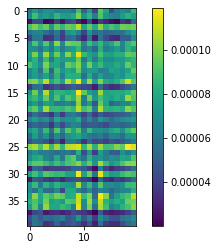

In [112]:
outputs  = dpe.multiply(2, x1, c_sel=[0, 20])
plt.imshow(outputs[:40])
plt.colorbar()
outputs = lin_corr(outputs, lin_cor_fc1)

In [90]:
# lin_cor_fc1 = [
#        [ 1.65705364e+01, -4.76661730e-06],
#        [ 1.52014391e+01, -7.32910667e-06],
#        [ 1.83622860e+01, -1.03660227e-04],
#        [ 1.46453131e+01,  8.72582481e-05],
#        [ 1.57026572e+01,  5.49433331e-06],
#        [ 1.75302910e+01, -5.91984363e-05],
#        [ 1.70097444e+01, -3.77425017e-06],
#        [ 1.66811834e+01, -5.92705383e-05],
#        [ 1.58138030e+01, -8.54206565e-05],
#        [ 1.47224922e+01, -1.01580546e-04],
#        [ 1.63933874e+01,  2.75899701e-05],
#        [ 1.73734414e+01, -6.44827939e-05],
#        [ 1.72284591e+01, -1.78498676e-05],
#        [ 1.56514926e+01,  4.85230992e-05],
#        [ 1.82551529e+01, -6.58699418e-05],
#        [ 1.80427640e+01,  3.35214924e-05],
#        [ 1.68846215e+01,  5.83922590e-05],
#        [ 1.78382218e+01, -5.84954866e-05],
#        [ 1.59426072e+01, -2.58419590e-05],
#        [ 1.77145924e+01, -3.09111781e-04]]

# lin_cor_fc2 = [
#        [ 1.49074642e+01,  3.04496037e-05],
#        [ 1.66134607e+01, -6.65273335e-05],
#        [ 1.71330302e+01, -1.16174943e-04],
#        [ 1.70197025e+01, -5.26536591e-05],
#        [ 1.57107974e+01, -7.15197241e-05],
#        [ 1.70294047e+01, -7.92741963e-05],
#        [ 1.73580128e+01, -7.60909714e-05],
#        [ 1.84105096e+01, -2.43281137e-05],
#        [ 1.68061704e+01, -2.11947699e-05],
#        [ 1.51725578e+01, -2.68254150e-05],
#        [ 1.85076350e+01, -3.41438100e-05],
#        [ 1.60115486e+01, -3.91897704e-05],
#        [ 1.56633900e+01,  5.07271500e-05],
#        [ 1.78045219e+01, -8.48122737e-05],
#        [ 1.53011229e+01,  6.33155863e-05],
#        [ 1.49990127e+01,  8.11595510e-05],
#        [ 1.75060714e+01,  4.32311953e-05],
#        [ 1.79812969e+01, -1.50383469e-04],
#        [ 1.58391025e+01,  3.87391613e-06],
#        [ 1.58795906e+01, -1.12594198e-04]]

In [91]:
output1  = dpe.multiply(2, x1, c_sel=[0, 20]) 
output1 = lin_corr(output1, lin_cor_fc1)

output2  = dpe.multiply(2, x2, c_sel=[20, 40])
output2 = lin_corr(output2, lin_cor_fc2)

outputs = output1 + output2

Connecting to serial
[INFO] Elapsed time = 1.89s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 1.89s
Serial disconnected


In [92]:
outputs = dpe.multiply(2, x2, c_sel=[20, 40]) 
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 1.89s
Serial disconnected


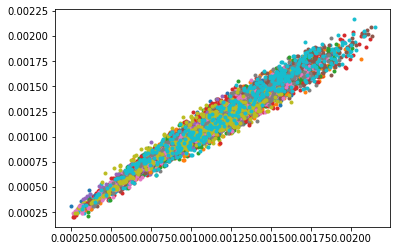

In [93]:
# lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = outputs[:,c]
    
    plt.plot(x,y,'.')

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([  3.,   3.,   3.,   3.,   9.,   6.,  12.,  18.,  31.,  37.,  46.,
         52.,  43.,  80., 103., 116., 149., 211., 196., 228., 259., 322.,
        381., 462., 504., 519., 494., 505., 473., 417., 366., 330., 297.,
        296., 238., 189., 152., 121.,  81.,  66.,  55.,  40.,  22.,  23.,
         16.,  11.,   6.,   3.,   2.,   1.]),
 array([-0.11500664, -0.11064888, -0.10629113, -0.10193337, -0.09757562,
        -0.09321786, -0.08886011, -0.08450235, -0.0801446 , -0.07578684,
        -0.07142909, -0.06707133, -0.06271358, -0.05835582, -0.05399807,
        -0.04964031, -0.04528256, -0.04092481, -0.03656705, -0.0322093 ,
        -0.02785154, -0.02349379, -0.01913603, -0.01477828, -0.01042052,
        -0.00606277, -0.00170501,  0.00265274,  0.0070105 ,  0.01136825,
         0.01572601,  0.02008376,  0.02444152,  0.02879927,  0.03315703,
         0.03751478,  0.04187254,  0.04623029,  0.05058805,  0.0549458 ,
         0.05930356,  0.06366131,  0.06801907,  0.07237682,  0.07673458,
 

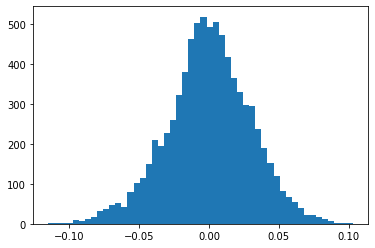

In [94]:
plt.hist((outputs-software).reshape(-1, 1)/0.0025, bins=50 )

In [95]:
(outputs-software).reshape(-1, 1).std()/0.0025

0.030066466724382183

In [18]:
# lin_cor_fc1 = [
#        [ 1.65705364e+01, -4.76661730e-06],
#        [ 1.52014391e+01, -7.32910667e-06],
#        [ 1.83622860e+01, -1.03660227e-04],
#        [ 1.46453131e+01,  8.72582481e-05],
#        [ 1.57026572e+01,  5.49433331e-06],
#        [ 1.75302910e+01, -5.91984363e-05],
#        [ 1.70097444e+01, -3.77425017e-06],
#        [ 1.66811834e+01, -5.92705383e-05],
#        [ 1.58138030e+01, -8.54206565e-05],
#        [ 1.47224922e+01, -1.01580546e-04],
#        [ 1.63933874e+01,  2.75899701e-05],
#        [ 1.73734414e+01, -6.44827939e-05],
#        [ 1.72284591e+01, -1.78498676e-05],
#        [ 1.56514926e+01,  4.85230992e-05],
#        [ 1.82551529e+01, -6.58699418e-05],
#        [ 1.80427640e+01,  3.35214924e-05],
#        [ 1.68846215e+01,  5.83922590e-05],
#        [ 1.78382218e+01, -5.84954866e-05],
#        [ 1.59426072e+01, -2.58419590e-05],
#        [ 1.77145924e+01, -3.09111781e-04]]

# lin_cor_fc2 = [
#        [ 1.49074642e+01,  3.04496037e-05],
#        [ 1.66134607e+01, -6.65273335e-05],
#        [ 1.71330302e+01, -1.16174943e-04],
#        [ 1.70197025e+01, -5.26536591e-05],
#        [ 1.57107974e+01, -7.15197241e-05],
#        [ 1.70294047e+01, -7.92741963e-05],
#        [ 1.73580128e+01, -7.60909714e-05],
#        [ 1.84105096e+01, -2.43281137e-05],
#        [ 1.68061704e+01, -2.11947699e-05],
#        [ 1.51725578e+01, -2.68254150e-05],
#        [ 1.85076350e+01, -3.41438100e-05],
#        [ 1.60115486e+01, -3.91897704e-05],
#        [ 1.56633900e+01,  5.07271500e-05],
#        [ 1.78045219e+01, -8.48122737e-05],
#        [ 1.53011229e+01,  6.33155863e-05],
#        [ 1.49990127e+01,  8.11595510e-05],
#        [ 1.75060714e+01,  4.32311953e-05],
#        [ 1.79812969e+01, -1.50383469e-04],
#        [ 1.58391025e+01,  3.87391613e-06],
#        [ 1.58795906e+01, -1.12594198e-04]]

def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [16]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, linear_factors_conv, c, x, i, result, x1, y, xs, acc, 


In [115]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[i*1000:(i+1)*1000]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20])
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40])
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    
ys = np.concatenate(ys)  

Accuracy = 91.70%


In [116]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9094

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [23]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

(26, 14)

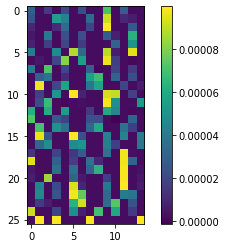

In [19]:
plt.imshow(finalGconv)
plt.colorbar()
np.shape(finalGconv)

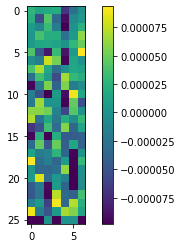

In [22]:
g1 = finalGconv[:,::2] - finalGconv[:,1::2]
plt.imshow(g1)
plt.colorbar()

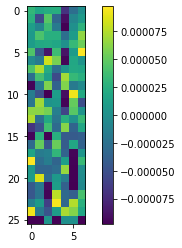

In [24]:
g2 = nn.Gconv[:,::2] - nn.Gconv[:,1::2]
plt.imshow(g2/2)
plt.colorbar()

(array([-5.0e-07,  0.0e+00,  5.0e-07,  1.0e-06,  1.5e-06,  2.0e-06,
         2.5e-06,  3.0e-06,  3.5e-06,  4.0e-06,  4.5e-06]),
 <a list of 11 Text xticklabel objects>)

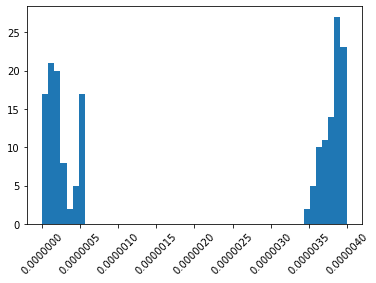

In [31]:
plt.hist((g2/2-g1).reshape(-1,1), bins=50)
plt.xticks(rotation=45)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *
vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)